<a href="https://colab.research.google.com/github/serenabooth/Scaffolding_RL/blob/master/6882_Scaffolding_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code is modified from https://cgnicholls.github.io/reinforcement-learning/2017/03/27/a3c.html

In [1]:
# install all the packages
!apt-get update
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym
!pip install "gym[atari]"
!pip install tqdm
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 252 kB in 2s (151 kB/s)
Reading package lists... Done
Reading package lists... Done
Building de

In [2]:
from pyvirtualdisplay import Display
from __future__ import print_function, division
from IPython.core import display
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import gym
from PIL import Image, ImageDraw
from gym.core import Wrapper
from gym.spaces.box import Box
import tensorflow as tf
import keras
from keras.layers import Conv2D, Dense, Flatten, Input, LSTM, Reshape
from keras.models import Model, Sequential
from tqdm import trange
from google.colab import files
import datetime
from time import time, sleep, gmtime, strftime
import uuid
import pickle
import random
import queue
# import multiprocessing
import threading

Using TensorFlow backend.


In [0]:
# used to enable Tensorboard
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1
! unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [5]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://54666631.ngrok.io


In [6]:
# mount Google drive - to store model checkpoints, etc
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
random.seed(100)

# FLAGS
T_MAX = 100000000
NUM_THREADS = 8
INITIAL_LEARNING_RATE = 1e-4
DISCOUNT_FACTOR = 0.99
VERBOSE_EVERY = 40000
TESTING = False

I_ASYNC_UPDATE = 5

FLAGS = {"T_MAX": T_MAX, "NUM_THREADS": NUM_THREADS, "INITIAL_LEARNING_RATE":
INITIAL_LEARNING_RATE, "DISCOUNT_FACTOR": DISCOUNT_FACTOR, "VERBOSE_EVERY":
VERBOSE_EVERY, "TESTING": TESTING, "I_ASYNC_UPDATE": I_ASYNC_UPDATE}

training_finished = False
last_T = None

In [0]:
display = Display(visible=0, size=(1400, 900))
display.start()

if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
# class CustomGym:
#     def __init__(self, game_name, skip_actions=4, num_frames=4, w=64, h=64, crop=lambda img: img):
#         self.env = gym.make(game_name)
#         self.num_frames = num_frames
#         self.skip_actions = skip_actions
#         self.w = w
#         self.h = h
#         self.crop = crop
#         if game_name == 'SpaceInvaders-v0':
#             self.action_space = [1,2,3] # For space invaders
#         elif game_name == 'Pong-v0':
#             self.action_space = [1,2,3]
#         elif game_name == 'Breakout-v0':
#             self.action_space = [1,4,5]
#         else:
#             # Use the actions specified by Open AI. Sometimes this has more
#             # actions than we want, and some actions do the same thing.
#             self.action_space = range(env.action_space.n)

#         self.action_size = len(self.action_space)
#         self.observation_shape = self.env.observation_space.shape

#         self.state = None
#         self.game_name = game_name

#     def preprocess(self, obs, is_start=False):
#         obs = self.crop(obs)
#         grayscale = obs.astype('float32').mean(2)
#         # s = imresize(grayscale, (self.w, self.h)).astype('float32') * (1.0/255.0)
#         grayscale = Image.fromarray(grayscale).resize((self.w, self.h))
#         s = np.array(grayscale).astype('float32') / 255.
#         s = s.reshape(1, s.shape[0], s.shape[1], 1)
#         if is_start or self.state is None:
#             self.state = np.repeat(s, self.num_frames, axis=3)
#         else:
#             self.state = np.append(s, self.state[:,:,:,:self.num_frames-1], axis=3)
#         return self.state

#     def render(self):
#         self.env.render()

#     def reset(self):
#         return self.preprocess(self.env.reset(), is_start=True)

#     def step(self, action_idx):
#         action = self.action_space[action_idx]
#         accum_reward = 0
#         prev_s = None
#         for _ in range(self.skip_actions):
#             s, r, term, info = self.env.step(action)
#             accum_reward += r
#             if term:
#                 break
#             prev_s = s
#         # Takes maximum value for each pixel value over the current and previous
#         # frame. Used to get round Atari sprites flickering (Mnih et al. (2015))
#         if self.game_name == 'SpaceInvaders-v0' and prev_s is not None:
#             s = np.maximum.reduce([s, prev_s])
#         return self.preprocess(s), accum_reward, term, info


class CustomGym(Wrapper):
    def __init__(self, env, game_name, skip_actions=4, num_frames=4, w=64, h=64, crop=lambda img: img):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(CustomGym, self).__init__(env)
        self.num_frames = num_frames
        self.skip_actions = skip_actions
        self.w = w
        self.h = h
        self.crop = crop
        if game_name == 'SpaceInvaders-v0':
            self.action_space = [1,2,3] # For space invaders
        elif game_name == 'Pong-v0':
            self.action_space = [1,2,3]
        elif game_name == 'Breakout-v0':
            self.action_space = [1,4,5]
        else:
            # Use the actions specified by Open AI. Sometimes this has more
            # actions than we want, and some actions do the same thing.
            self.action_space = range(env.action_space.n)

        self.action_size = len(self.action_space)
        self.observation_space = env.observation_space
        self.observation_shape = env.observation_space.shape
        
        self.state = None
        self.game_name = game_name

    def preprocess(self, obs, is_start=False):
        obs = self.crop(obs)
        grayscale = obs.astype('float32').mean(2)
        # s = imresize(grayscale, (self.w, self.h)).astype('float32') * (1.0/255.0)
        grayscale = Image.fromarray(grayscale).resize((self.w, self.h))
        s = np.array(grayscale).astype('float32') / 255.
        s = s.reshape(1, s.shape[0], s.shape[1], 1)
        if is_start or self.state is None:
            self.state = np.repeat(s, self.num_frames, axis=3)
        else:
            self.state = np.append(s, self.state[:,:,:,:self.num_frames-1], axis=3)
        return self.state

#     def render(self):
#         self.env.render()

    def reset(self):
        return self.preprocess(self.env.reset(), is_start=True)

    def step(self, action_idx):
        action = self.action_space[action_idx]
        accum_reward = 0
        prev_s = None
        for _ in range(self.skip_actions):
            s, r, term, info = self.env.step(action)
            accum_reward += r
            if term:
                break
            prev_s = s
        # Takes maximum value for each pixel value over the current and previous
        # frame. Used to get round Atari sprites flickering (Mnih et al. (2015))
        if self.game_name == 'SpaceInvaders-v0' and prev_s is not None:
            s = np.maximum.reduce([s, prev_s])
        return self.preprocess(s), accum_reward, term, info


Observation shape: (210, 160, 3)
Num actions: 3
Action names: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Actions: [1, 2, 3]


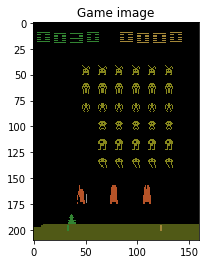

(1, 64, 64, 4)


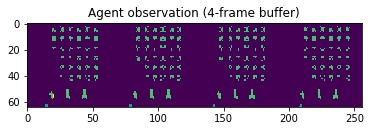

In [132]:
# env = CustomGym(game_name="SpaceInvaders-v0", crop=lambda img: img[35:-20, :], h=64, w=64)

def make_env():
    env = gym.make("SpaceInvaders-v0")
    env = CustomGym(env, game_name="SpaceInvaders-v0", crop=lambda img: img[35:-20, :], h=64, w=64)
    return env

env = make_env()

obs_shape = env.observation_shape
n_actions = env.action_size

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())
print("Actions:", env.action_space)

s = env.reset()
accum_reward = 0
for _ in range(100):
    s, reward, _, _ = env.step(random.randint(0,n_actions)-1)
    accum_reward += reward

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
print(s.shape)
plt.imshow(s[0].transpose([0,2,1]).reshape([64,-1]))
plt.show()

In [0]:
class Agent():
    def __init__(self, session, action_size, optimizer=tf.train.AdamOptimizer(INITIAL_LEARNING_RATE)):

        self.action_size = action_size
        self.optimizer = optimizer
        self.sess = session

        with tf.variable_scope('network'):
            self.action = tf.placeholder('int32', [None], name='action')
            self.target_value = tf.placeholder('float32', [None], name='target_value')

            self.state, self.policy, self.value = self.build_model(64, 64, 4)
            self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
            scope='network')
            self.advantages = tf.placeholder('float32', [None], name='advantages')

        with tf.variable_scope('optimizer'):
            # Compute the one hot vectors for each action given.
            action_one_hot = tf.one_hot(self.action, self.action_size, 1.0, 0.0)

            # Clipping required to play nice with logs (0,1)
            min_policy = 1e-8
            max_policy = 1.0 - 1e-8
            self.log_policy = tf.log(tf.clip_by_value(self.policy, 0.000001, 0.999999))

            # For a given state and action, compute the log of the policy at
            # that action for that state. This also works on batches.
            self.log_pi_for_action = tf.reduce_sum(tf.multiply(self.log_policy, action_one_hot), reduction_indices=1)

            # Takes in R_t - V(s_t) as in the async paper. Note that we feed in
            # the advantages so that V(s_t) is treated as a constant for the
            # gradient. This is because V(s_t) is the baseline (called 'b' in
            # the REINFORCE algorithm). As long as the baseline is constant wrt
            # the parameters we are optimising (in this case those for the
            # policy), then the expected value of grad_theta log pi * b is zero,
            # so the choice of b doesn't affect the expectation. It reduces the
            # variance though.
            # We want to do gradient ascent on the expected discounted reward.
            # The gradient of the expected discounted reward is the gradient of
            # log pi * (R - estimated V), where R is the sampled reward from the
            # given state following the policy pi. Since we want to maximise
            # this, we define the policy loss as the negative and get tensorflow
            # to do the automatic differentiation for us.
            self.policy_loss = -tf.reduce_mean(self.log_pi_for_action * self.advantages)

            # The value loss is much easier to understand: we want our value
            # function to accurately estimated the sampled discounted rewards,
            # so we just impose a square error loss.
            # Note that the target value should be the discounted reward for the
            # state as just sampled.
            self.value_loss = tf.reduce_mean(tf.square(self.target_value - self.value))

            # We follow Mnih's paper and introduce the entropy as another loss
            # to the policy. The entropy of a probability distribution is just
            # the expected value of - log P(X), denoted E(-log P(X)), which we
            # can compute for our policy at any given state with
            # sum(policy * -log(policy)), as below. This will be a positive
            # number, since self.policy contains numbers between 0 and 1, so the
            # log is negative. Note that entropy is smaller when the probability
            # distribution is more concentrated on one action, so a larger
            # entropy implies more exploration. Thus we penalise small entropy,
            # or equivalently, add -entropy to our loss.
            self.entropy = tf.reduce_sum(tf.multiply(self.policy, -self.log_policy))

            # Try to minimise the loss. There is some rationale for choosing the
            # weighted linear combination here that I found somewhere else that
            # I can't remember, but I haven't tried to optimise it.
            # Note the negative entropy term, which encourages exploration:
            # higher entropy corresponds to less certainty.
            self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy\
            * 0.01

            # Compute the gradient of the loss with respect to all the weights,
            # and create a list of tuples consisting of the gradient to apply to
            # the weight.
            grads = tf.gradients(self.loss, self.weights)
            grads, _ = tf.clip_by_global_norm(grads, 40.0)
            grads_vars = list(zip(grads, self.weights))

            # Create an operator to apply the gradients using the optimizer.
            # Note that apply_gradients is the second part of minimize() for the
            # optimizer, so will minimize the loss.
            self.train_op = optimizer.apply_gradients(grads_vars)

    def get_policy(self, state):
        return self.sess.run(self.policy, {self.state: state}).flatten()

    def get_value(self, state):
        return self.sess.run(self.value, {self.state: state}).flatten()

    def get_policy_and_value(self, state):
        policy, value = self.sess.run([self.policy, self.value], {self.state:
        state})
        return policy.flatten(), value.flatten()

    # Train the network on the given states and rewards
    def train(self, states, actions, target_values, advantages):
        # Training
        self.sess.run(self.train_op, feed_dict={
            self.state: states,
            self.action: actions,
            self.target_value: target_values,
            self.advantages: advantages
        })

    # Builds the DQN model as in Mnih, but we get a softmax output for the
    # policy from fc1 and a linear output for the value from fc1.
    def build_model(self, h, w, channels):
        self.layers = {}
        state = tf.placeholder('float32', shape=(None, h, w, channels), name='state')
        self.layers['state'] = state
        # First convolutional layer
        with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE):
            conv1 = tf.contrib.layers.convolution2d(inputs=state,
            num_outputs=16, kernel_size=[8,8], stride=[4,4], padding="VALID",
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
            biases_initializer=tf.zeros_initializer())
            self.layers['conv1'] = conv1

        # Second convolutional layer
        with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE):
            conv2 = tf.contrib.layers.convolution2d(inputs=conv1, num_outputs=32,
            kernel_size=[4,4], stride=[2,2], padding="VALID",
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
            biases_initializer=tf.zeros_initializer())
            self.layers['conv2'] = conv2

        # Flatten the network
        with tf.variable_scope('flatten', reuse=tf.AUTO_REUSE):
            flatten = tf.contrib.layers.flatten(inputs=conv2)
            self.layers['flatten'] = flatten

        # Fully connected layer with 256 hidden units
        with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
            fc1 = tf.contrib.layers.fully_connected(inputs=flatten, num_outputs=256,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=tf.zeros_initializer())
            self.layers['fc1'] = fc1

        # The policy output
        with tf.variable_scope('policy', reuse=tf.AUTO_REUSE):
            policy = tf.contrib.layers.fully_connected(inputs=fc1,
            num_outputs=self.action_size, activation_fn=tf.nn.softmax,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=None)
            self.layers['policy'] = policy

        # The value output
        with tf.variable_scope('value', reuse=tf.AUTO_REUSE):
            value = tf.contrib.layers.fully_connected(inputs=fc1, num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer(),
            biases_initializer=None)
            self.layers['value'] = value

        return state, policy, value

In [0]:
class Summary:
    def __init__(self, logdir, agent):
        with tf.variable_scope('summary'):
            summarising = ['episode_avg_reward', 'avg_value']
            self.agent = agent
            self.writer = tf.summary.FileWriter(logdir, self.agent.sess.graph)
            self.summary_ops = {}
            self.summary_vars = {}
            self.summary_ph = {}
            for s in summarising:
                self.summary_vars[s] = tf.Variable(0.0)
                self.summary_ph[s] = tf.placeholder('float32', name=s)
                self.summary_ops[s] = tf.summary.scalar(s, self.summary_vars[s])
            self.update_ops = []
            for k in self.summary_vars:
                self.update_ops.append(self.summary_vars[k].assign(self.summary_ph[k]))
            self.summary_op = tf.summary.merge(list(self.summary_ops.values()))

    def write_summary(self, summary, t):
        self.agent.sess.run(self.update_ops, {self.summary_ph[k]: v for k, v in summary.items()})
        summary_to_add = self.agent.sess.run(self.summary_op, {self.summary_vars[k]: v for k, v in summary.items()})
        self.writer.add_summary(summary_to_add, global_step=t)

In [0]:
def async_trainer(agent, env, sess, thread_idx, T_queue, summary, saver,
    save_path):
    print ("Training thread", thread_idx)
    T = T_queue.get()
    T_queue.put(T+1)
    t = 0

    last_verbose = T
    last_time = time()
    last_target_update = T

    terminal = True
    while T < T_MAX:
        t_start = t
        batch_states = []
        batch_rewards = []
        batch_actions = []
        baseline_values = []

        if terminal:
            terminal = False
            state = env.reset()

        while not terminal and len(batch_states) < I_ASYNC_UPDATE:
            # Save the current state
            batch_states.append(state)

            # Choose an action randomly according to the policy
            # probabilities. We do this anyway to prevent us having to compute
            # the baseline value separately.
            policy, value = agent.get_policy_and_value(state)
            action_idx = np.random.choice(agent.action_size, p=policy)

            # Take the action and get the next state, reward and terminal.
            state, reward, terminal, _ = env.step(action_idx)

            # Update counters
            t += 1
            T = T_queue.get()
            T_queue.put(T+1)

            # Clip the reward to be between -1 and 1
            reward = np.clip(reward, -1, 1)

            # Save the rewards and actions
            batch_rewards.append(reward)
            batch_actions.append(action_idx)
            baseline_values.append(value[0])

        target_value = 0
        # If the last state was terminal, just put R = 0. Else we want the
        # estimated value of the last state.
        if not terminal:
            target_value = agent.get_value(state)[0]
        last_R = target_value

        # Compute the sampled n-step discounted reward
        batch_target_values = []
        for reward in reversed(batch_rewards):
            target_value = reward + DISCOUNT_FACTOR * target_value
            batch_target_values.append(target_value)
        # Reverse the batch target values, so they are in the correct order
        # again.
        batch_target_values.reverse()

        # Test batch targets
        if TESTING:
            temp_rewards = batch_rewards + [last_R]
            test_batch_target_values = []
            for j in range(len(batch_rewards)):
                test_batch_target_values.append(discount(temp_rewards[j:], DISCOUNT_FACTOR))
            if not test_equals(batch_target_values, test_batch_target_values,
                1e-5):
                print ("Assertion failed")
                print (last_R)
                print (batch_rewards)
                print (batch_target_values)
                print (test_batch_target_values)

        # Compute the estimated value of each state
        batch_advantages = np.array(batch_target_values) - np.array(baseline_values)

        # Apply asynchronous gradient update
        agent.train(np.vstack(batch_states), batch_actions, batch_target_values,
        batch_advantages)

    global training_finished
    training_finished = True

In [0]:
def estimate_reward(agent, env, episodes=10, max_steps=10000):
    episode_rewards = []
    episode_vals = []
    t = 0
    for i in range(episodes):
        episode_reward = 0
        state = env.reset()
        terminal = False
        while not terminal:
            policy, value = agent.get_policy_and_value(state)
            action_idx = np.random.choice(agent.action_size, p=policy)
            state, reward, terminal, _ = env.step(action_idx)
            t += 1
            episode_vals.append(value)
            episode_reward += reward
            if t > max_steps:
                episode_rewards.append(episode_reward)
                return episode_rewards, episode_vals
        episode_rewards.append(episode_reward)
    return episode_rewards, episode_vals

In [0]:
def evaluator(agent, env, sess, T_queue, summary, saver, save_path):
    # Read T and put the same T back on.
    T = T_queue.get()
    T_queue.put(T)
    last_time = time()
    last_verbose = T
    
    rewards_history = []
    while T < T_MAX:
        T = T_queue.get()
        T_queue.put(T)
        if T - last_verbose >= VERBOSE_EVERY:
            print ("T", T)
            current_time = time()
            print ("Train steps per second", float(T - last_verbose) / (current_time - last_time))
            last_time = current_time
            last_verbose = T

            print ("Evaluating agent")
            episode_rewards, episode_vals = estimate_reward(agent, env, episodes=5)
            avg_ep_r = np.mean(episode_rewards)
            avg_val = np.mean(episode_vals)
            print ("Avg ep reward", avg_ep_r, "Average value", avg_val)
            
            rewards_history.append(avg_ep_r)
            
            clear_output(True)
            plt.figure(figsize=[8,4])
            plt.subplot(1,2,1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(pd.DataFrame(np.array(rewards_history)).ewm(span=10).mean(), marker='.', label='rewards ewma@10')
            plt.title("Session rewards"); plt.grid(); plt.legend()
            plt.show()
        
            global last_T
            last_t = T
            
            summary.write_summary({'episode_avg_reward': avg_ep_r, 'avg_value': avg_val}, T)
            checkpoint_file = saver.save(sess, save_path, global_step=T)
            print ("Saved in", checkpoint_file)
        sleep(1.0)

In [0]:
def a3c(game_name, num_threads=8, restore=None, save_path='model'):
    processes = []
    envs = []
    
    # create num_threads + 1 environments 
    for _ in range(num_threads+1):
        gym_env = gym.make(game_name)
        print ("Assuming ATARI game and playing with pixels")
        env = make_env()
        envs.append(env)

    # Separate out the evaluation environment
    evaluation_env = envs[0]
    envs = envs[1:]

    with tf.Session() as sess:
        agent = Agent(session=sess,
        action_size=envs[0].action_size,
        optimizer=tf.train.AdamOptimizer(INITIAL_LEARNING_RATE))

        # Create a saver, and only keep 2 checkpoints.
        saver = tf.train.Saver(max_to_keep=2)

        T_queue = queue.Queue()

        # Either restore the parameters or don't.
        if restore is not None:
            saver.restore(sess, save_path + '-' + str(restore))
            last_T = restore
            print ("T was:", last_T)
            T_queue.put(last_T)
        else:
            sess.run(tf.global_variables_initializer())
            T_queue.put(0)

        summary = Summary(LOG_DIR, agent)

        # Create a process for each worker
        for i in range(num_threads):
            processes.append(threading.Thread(target=async_trainer, args=(agent,
            envs[i], sess, i, T_queue, summary, saver, save_path,)))

        # Create a process to evaluate the agent
        processes.append(threading.Thread(target=evaluator, args=(agent,
        evaluation_env, sess, T_queue, summary, saver, save_path,)))

        # Start all the processes
        for p in processes:
            p.daemon = True
            p.start()

        # Until training is finished
        while not training_finished:
            sleep(0.01)

        # Join the processes, so we get this thread back.
        for p in processes:
            p.join()

# Returns sum(rewards[i] * gamma**i)
def discount(rewards, gamma):
    return np.sum([rewards[i] * gamma**i for i in range(len(rewards))])

def test_equals(arr1, arr2, eps):
    return np.sum(np.abs(np.array(arr1)-np.array(arr2))) < eps

In [125]:
model_id = model_id = str(datetime.date.today()) + "-" + str(uuid.uuid1())
print(model_id)

2019-05-03-5cf8c1c8-6df4-11e9-ae34-0242ac1c0002


In [133]:
tf.reset_default_graph()

save_path = F"/content/gdrive/My Drive/RL_models/" + model_id
restore = None
game_name = "SpaceInvaders-v0"

reward_history = []

a3c(game_name, num_threads=NUM_THREADS, restore=None,
    save_path=save_path)

Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Assuming ATARI game and playing with pixels
Training thread 0Training thread
 1
Training thread 2
Training thread 3
Training thread 4
Training thread 5
Training thread 6
Training thread 7


Exception in thread Thread-58:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1334, in _do_call
    return fn(*args)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1319, in _run_fn
    options, feed_dict, fetch_list, target_list, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1407, in _call_tf_sessionrun
    run_metadata)
tensorflow.python.framework.errors_impl.CancelledError: Run call was cancelled

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-118-82449cca8adc>", line 85, in async_trainer
    batch_advantages)
  File "<ipython-input-116-3d4e

KeyboardInterrupt: ignored

Exception in thread Thread-56:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-118-82449cca8adc>", line 31, in async_trainer
    policy, value = agent.get_policy_and_value(state)
  File "<ipython-input-116-3d4e7948bc6f>", line 92, in get_policy_and_value
    state})
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 929, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1075, in _run
    raise RuntimeError('Attempted to use a closed Session.')
RuntimeError: Attempted to use a closed Session.

Exception in thread Thread-57:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py

In [0]:
def play(agent, game_name, num_episodes=10, fps=5.0, monitor=True):
#     gym_env = gym.make(game_name)
#     if monitor:
#         print(gym_env)
#         gym_env = gym.wrappers.Monitor(gym_env, directory="SI_videos", video_callable=lambda episode_id: True, force=True)
#     print (gym_env)
#     print(game_name)
    env = make_env()
    env = gym.wrappers.Monitor(env, directory="SI_videos", video_callable=lambda episode_id: True, force=True)

    desired_frame_length = 1.0 / fps

    episode_rewards = []
    episode_vals = []
    t = 0
    for ep in range(num_episodes):
        print ("Starting episode", ep)
        episode_reward = 0
        state = env.reset()
        print (state.shape)
        terminal = False
        current_time = time()
        while not terminal:
            policy, value = agent.get_policy_and_value(state)
            action_idx = np.random.choice(agent.action_size, p=policy)
            state, reward, terminal, _ = env.step(action_idx)
            t += 1
            episode_vals.append(value)
            episode_reward += reward
            # Sleep so the frame rate is correct
            next_time = time()
            frame_length = next_time - current_time
            if frame_length < desired_frame_length:
                sleep(desired_frame_length - frame_length)
            current_time = next_time
        episode_rewards.append(episode_reward)
    return episode_rewards, episode_vals

def run_agent(save_path, T, game_name):
    with tf.Session() as sess:
        agent = Agent(session=sess,
        action_size=3,
        optimizer=tf.train.AdamOptimizer(1e-4))

        # Create a saver, and restore checkpoint.
        saver = tf.train.Saver()
        saver.restore(sess, save_path + '-' + str(T))

        episode_rewards, episode_vals = play(agent, game_name, num_episodes=2)

        return sess, agent, episode_rewards, episode_vals

In [134]:
tf.reset_default_graph()
# call to run the agent 
print (last_T)
s, a, e_r, e_v = run_agent(F"/content/gdrive/My Drive/RL_models/" + "2019-05-03-506b9b98-6de4-11e9-ae34-0242ac1c0002", 280797, game_name)
print (e_r)

None
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/RL_models/2019-05-03-506b9b98-6de4-11e9-ae34-0242ac1c0002-280797
Starting episode 0
(1, 64, 64, 4)
Starting episode 1
(1, 64, 64, 4)
[110.0, 50.0]


In [137]:
video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./SI_videos/")))
print(video_names)

['openaigym.video.15.14956.video000001.mp4', 'openaigym.video.15.14956.video000000.mp4']


In [0]:
files.download('./SI_videos/openaigym.video.15.14956.video000001.mp4')